In [1]:
%%capture
#!pip install hdbscan
#!pip install clusteval
#!pip install umap-learn

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

#import plotly_express as px
import plotly.graph_objs as go
#import plotly.plotly as py
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#import umap
#import umap.umap_ as umap

import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
import pickle
import time

from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

#from clusteval import clusteval


In [3]:
'''
from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/Colab Notebooks/Projects/L2C4/"
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\nproject_path = "/content/drive/MyDrive/Colab Notebooks/Projects/L2C4/"\n'

In [4]:
project_path = ""

In [5]:
'''
%%capture
!wget https://raw.githubusercontent.com/sarthakrastogi/L2C4/main/clustering.py
!wget https://raw.githubusercontent.com/sarthakrastogi/L2C4/main/clustering_optimal_algos.py
'''

'\n%%capture\n!wget https://raw.githubusercontent.com/sarthakrastogi/L2C4/main/clustering.py\n!wget https://raw.githubusercontent.com/sarthakrastogi/L2C4/main/clustering_optimal_algos.py\n'

In [6]:
'''
%%capture
!pip install chart_studio
!pip install clusteval

import chart_studio.plotly as py
import plotly.graph_objs as go
'''

'\n%%capture\n!pip install chart_studio\n!pip install clusteval\n\nimport chart_studio.plotly as py\nimport plotly.graph_objs as go\n'

In [7]:
def make_df(graph):
    df = pd.DataFrame(list(graph.items()))

    df.rename(columns = {0:'word', 1:'vector'}, inplace = True)
    df[[i for i in range(0, 50)]] = pd.DataFrame(df['vector'].tolist(), index=df.index)
    df.drop('vector', axis=1, inplace=True)
    
    df = df.drop('word', axis=1)

    return df


def apply_pca(df):
    pca = PCA(n_components=25)
    res = pca.fit_transform(df)
    print("Explained variance:", pca.explained_variance_ratio_.sum())
    return res


def apply_tsne(df):#, perplexity, n_iter):
    tsne = TSNE(n_components=2)#, perplexity=perplexity, n_iter=n_iter)
    v2d = tsne.fit_transform(df)
    return v2d


def apply_umap(df):
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(df)
    #print(reducer.explained_variance_ratio_.sum())
    return embedding


def apply_svd(df):
    
    u, s, v = np.linalg.svd(df, full_matrices=True)
    print(np.round(s**2/np.sum(s**2), decimals=3))
    labels= ['SV'+str(i) for i in range(1,3)]
    svd_df = pd.DataFrame(u[:,0:2], 
                          #index=lifeExp_meta["continent"].tolist(), 
                          columns=labels)
    #svd_df=svd_df.reset_index()
    #svd_df.drop('index', inplace=True, axis=1)
    return svd_df.values

def clustevalres(X):
    ce = clusteval(evaluate='silhouette')
    ce.fit(X)
    #ce.plot()
    #ce.dendrogram()
    ce.scatter(X)

    ce = clusteval(evaluate='dbindex')
    ce.fit(X)
    #ce.plot()
    ce.scatter(X)
    #ce.dendrogram()

    ce = clusteval(cluster='dbscan')
    try:
        ce.fit(X)
        ce.plot()
        ce.scatter(X)
    except ValueError:
        pass
    #ce.dendrogram()

    ce = clusteval(cluster='hdbscan')
    ce.fit(X)
    #ce.plot()
    ce.scatter(X)
    #ce.dendrogram()

    
def vary_damping(graph, algo):
    best_damping = 0
    max_sil = 0
    for damping in [0.5, 0.6, 0.7, 0.8, 0.9]:
        if True:#try:
            sil, pct = algo(graph, damping=damping)
        #except ValueError:
         #   pass
        
        if sil > max_sil:
            max_sil = sil
            best_damping = damping

    return best_damping

        
def vary_n_of_clusters(graph, algo):
    best_n = 0
    max_sil = 0
    for n in range(6, 20):
        sil, pct = algo(graph, n)
        
        if sil > max_sil:
            max_sil = sil
            best_n = n
    return best_n
  
        
        
def vary_min_samples(graph, algo):
    best_n = 0
    max_sil = 0
    for n in range(4, 15):
        sil, pct = (graph, n)
        
        if sil > max_sil:
            max_sil = sil
            best_n=n
    return best_n


def make_tensors(graph):
    import torch
    return {k : torch.FloatTensor(v).to(cuda) for k, v in graph.items()}

In [8]:
#project_path = ""

In [9]:
def load_graph(lang1, lang2):
    with open(project_path + "Graphs/" + str(lang1) + "_" + str(lang2) + "_" + "graph.pickle", 'rb') as f:
        return pickle.load(f)

------

# 1. Samskrit and Latin

In [11]:
sa_la_graph = load_graph('sa', 'la')
df = apply_tsne(apply_pca(make_df(sa_la_graph)))

Explained variance: 0.8544635623438387


In [12]:
import warnings
warnings.filterwarnings("ignore")

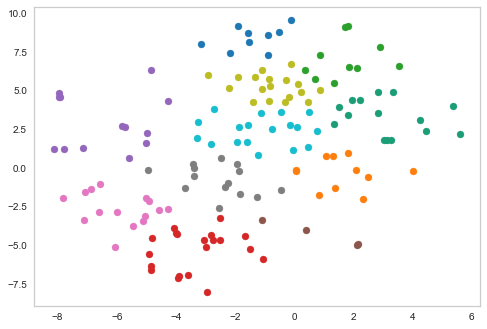

Sillhouette score:  0.5214341921570916
Percentage score:  0.7607170960785459
Number of clusters:  11


In [13]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

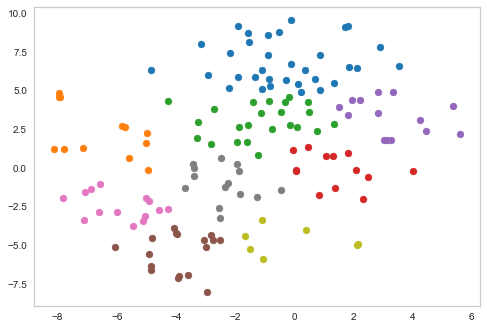

Sillhouette score:  0.5096875715758398
Percentage score:  0.7548437857879199
Number of clusters:  9
9


In [14]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)
print(n)

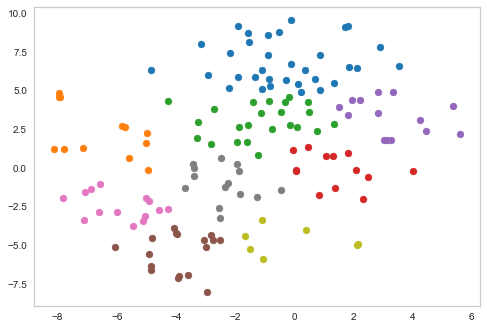

Sillhouette score:  0.5096875715758398
Percentage score:  0.7548437857879199
Number of clusters:  9
9


In [15]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)
print(n)

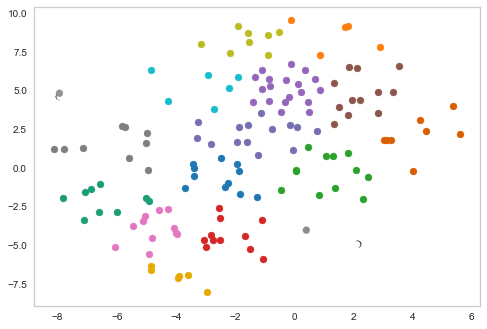

Sillhouette score:  0.544555442309671
Percentage score:  0.7722777211548355
Number of clusters:  16
16


In [16]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)
print(n)

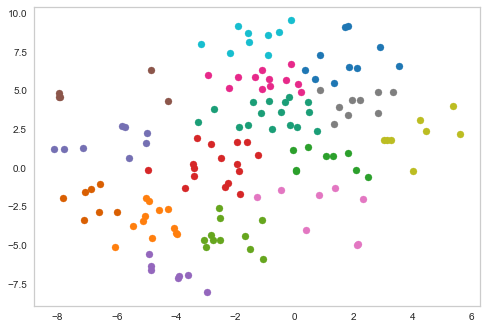

Sillhouette score:  0.5067973191140941
Percentage score:  0.753398659557047
Number of clusters:  15


In [17]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

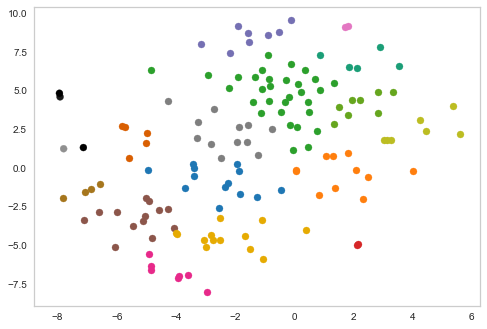

Sillhouette score:  0.44349082317394317
Percentage score:  0.7217454115869716
Number of clusters:  17


In [18]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

In [19]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

# 2. Samskrit and Hindi

In [20]:
sa_hi_graph = load_graph('sa', 'hi')
df = apply_tsne(apply_pca(make_df(sa_hi_graph)))

Explained variance: 0.7953388277970651


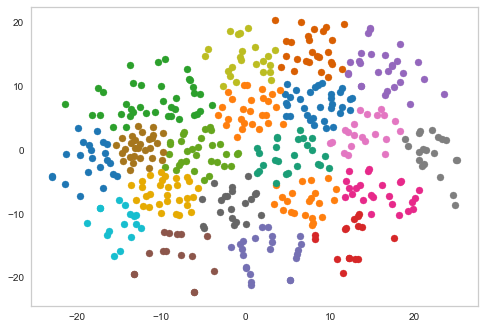

Sillhouette score:  0.5073318157093245
Percentage score:  0.7536659078546623
Number of clusters:  21


In [21]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

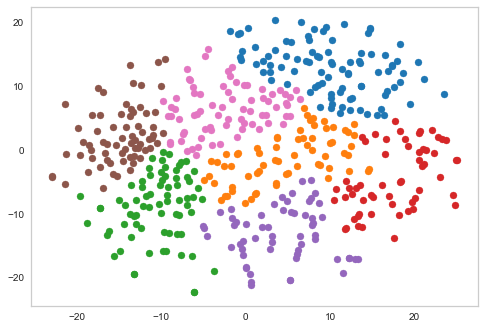

Sillhouette score:  0.44260375693405873
Percentage score:  0.7213018784670293
Number of clusters:  7


In [22]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

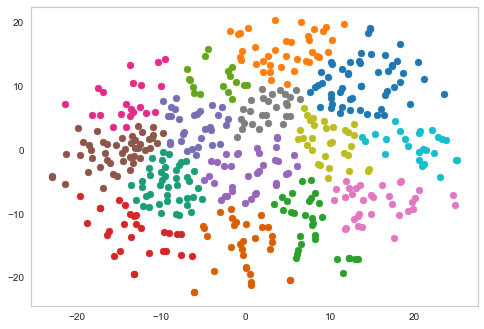

Sillhouette score:  0.4469845654102363
Percentage score:  0.7234922827051181
Number of clusters:  15


In [23]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

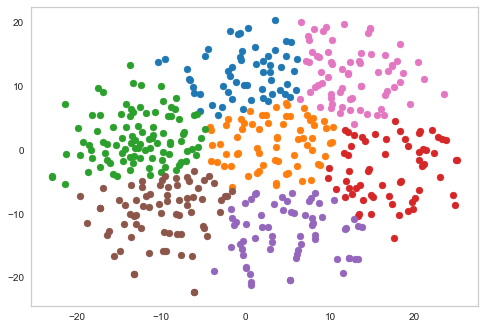

Sillhouette score:  0.5268538603823925
Percentage score:  0.7634269301911962
Number of clusters:  7


In [24]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

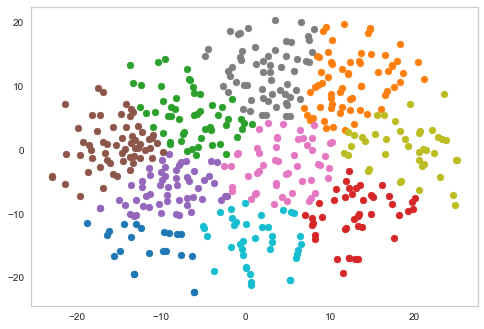

Sillhouette score:  0.4786203728495343
Percentage score:  0.7393101864247671
Number of clusters:  10


In [25]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [26]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
try: spectral_clustering(df, n=n)
except: pass

In [27]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

# 3. Hindi and English

In [28]:
hi_en_graph = load_graph('hi', 'en')
df = apply_tsne(apply_pca(make_df(hi_en_graph)))

Explained variance: 0.7516133032381147


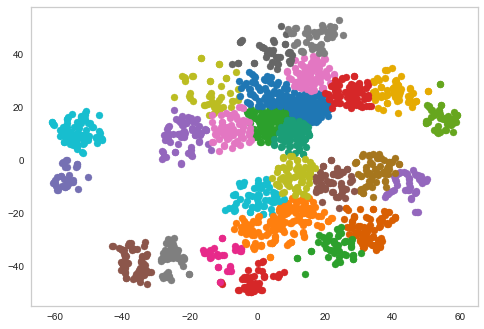

Sillhouette score:  0.5397068833927076
Percentage score:  0.7698534416963538
Number of clusters:  43


In [29]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = 0.9#vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

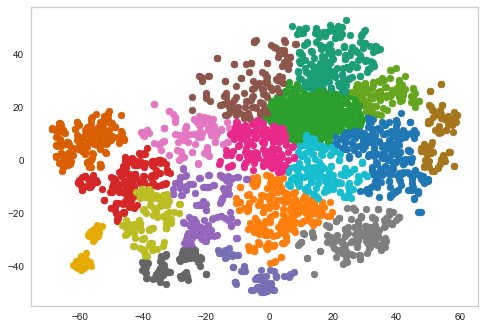

Sillhouette score:  0.475102839623668
Percentage score:  0.737551419811834
Number of clusters:  18


In [30]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

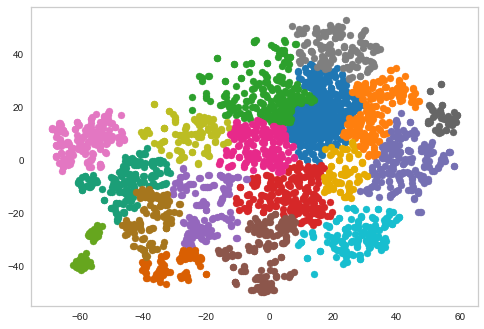

Sillhouette score:  0.4377749534195436
Percentage score:  0.7188874767097718
Number of clusters:  18


In [31]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

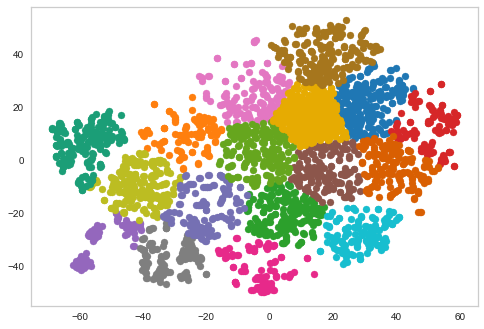

Sillhouette score:  0.558771221506651
Percentage score:  0.7793856107533255
Number of clusters:  17


In [32]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

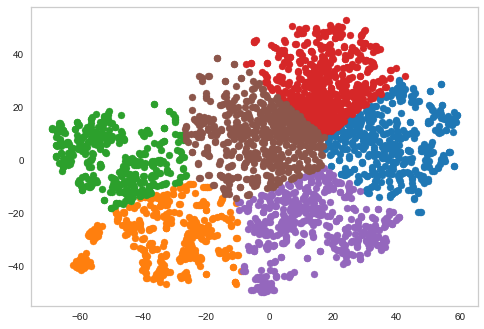

Sillhouette score:  0.5429119228501145
Percentage score:  0.7714559614250572
Number of clusters:  6


In [33]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

In [ ]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

# 4. German and English

In [ ]:
de_en_graph = load_graph('de', 'en')
df = apply_tsne(apply_pca(make_df(de_en_graph)))

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = 0.8# vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

In [ ]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

In [ ]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

# 5. Latin and English

In [ ]:
la_en_graph = load_graph('la', 'en')
df = apply_tsne(apply_pca(make_df(la_en_graph)))

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = 0.8#vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

In [ ]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

In [ ]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

# 6. Latin and French

In [ ]:
la_fr_graph = load_graph('la', 'fr')
df = apply_tsne(apply_pca(make_df(la_fr_graph)))

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = 0.9# vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

In [ ]:
vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

In [ ]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

# 7. Hindi and Tamil

In [ ]:
hi_ta_graph = load_graph('hi', 'ta')
df = apply_tsne(apply_pca(make_df(hi_ta_graph)))

In [ ]:
#clustevalres(df)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
d = vary_damping(df, cluster_with_affinity_propagation)
from clustering import cluster_with_affinity_propagation
cluster_with_affinity_propagation(df, damping = d)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, agglomerative_clustering)
from clustering import agglomerative_clustering
agglomerative_clustering(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_birch)
from clustering import cluster_with_birch
cluster_with_birch(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_kmeans)
from clustering import cluster_with_kmeans
cluster_with_kmeans(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, cluster_with_mini_batch_kmeans)
from clustering import cluster_with_mini_batch_kmeans
cluster_with_mini_batch_kmeans(df, n=n)

In [ ]:
from clustering_optimal_algos import cluster_with_affinity_propagation, agglomerative_clustering, cluster_with_birch, cluster_with_kmeans, cluster_with_mini_batch_kmeans, spectral_clustering, mean_shift_clustering
n = vary_n_of_clusters(df, spectral_clustering)
from clustering import spectral_clustering
spectral_clustering(df, n=n)

In [ ]:
from clustering import mean_shift_clustering
try: mean_shift_clustering(df)
except: pass

---

'https://machinelearningmastery.com/clustering-algorithms-with-python/'